In [2]:
# Import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

print('All imports were successful!')

All imports were successful!


In [4]:
# Load the butterfly dataset
df_training = pd.read_csv("/Users/shrutiraj/Downloads/archive-2/Training_set.csv")
df_testing = pd.read_csv("/Users/shrutiraj/Downloads/archive-2/Testing_set.csv")

In [6]:
df_training.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [8]:
df_testing.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [10]:
# Split the training dataset into training and validation sets
train_data, val_data = train_test_split(df_training, test_size=0.2, random_state=42)

# Define image directory path
image_dir = '/Users/shrutiraj/Downloads/archive-2/train'

In [12]:
# Data augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Load training data with ImageDataGenerator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Load validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


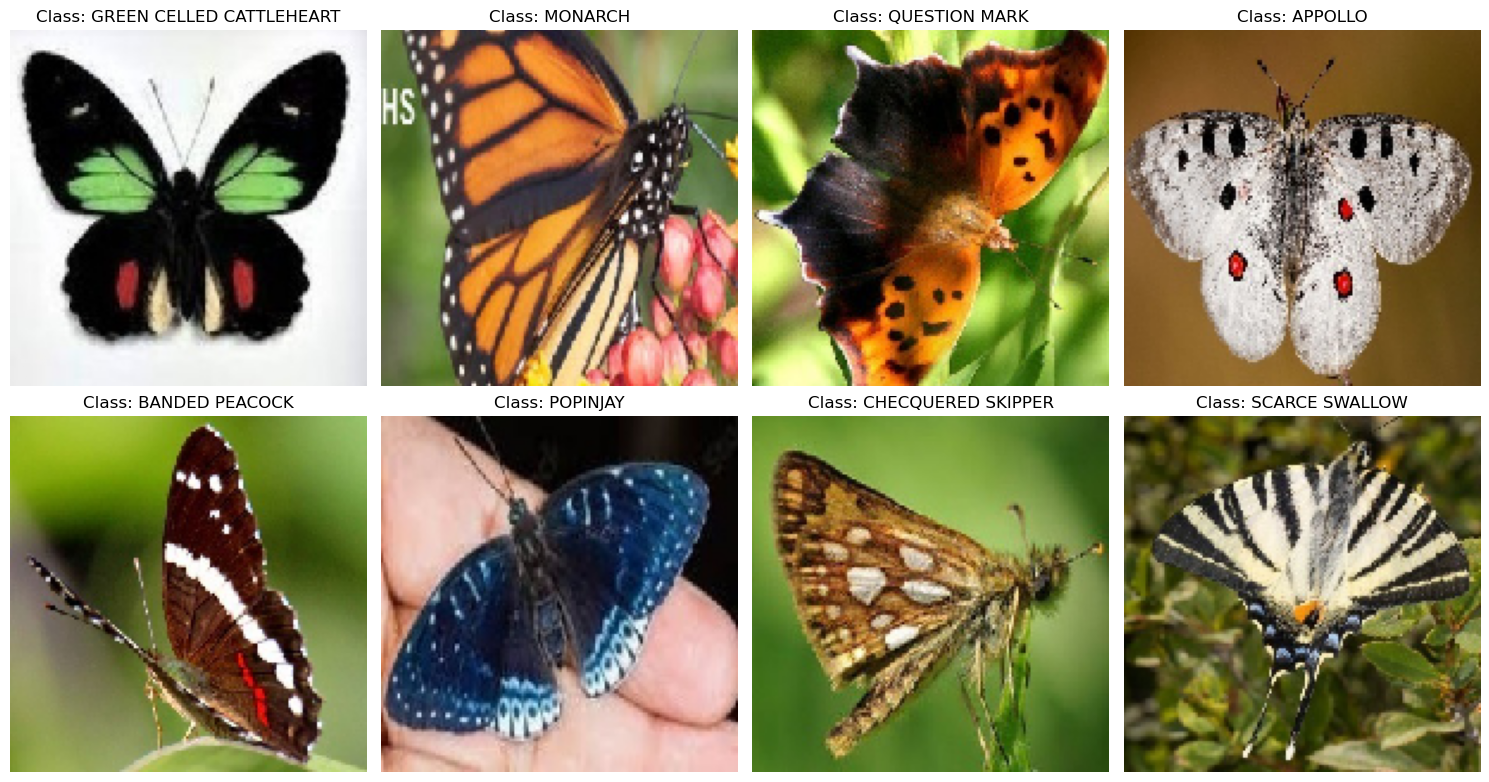

In [16]:
# Create a grid for displaying butterflies
fig4, axes = plt.subplots(2, 4, figsize=(15, 8))

# Randomly sample
sample_images = df_training.sample(8, random_state=42)

# Display images
for i, (index, row) in enumerate(sample_images.iterrows()):
    image_path = os.path.join(image_dir, row['filename'])
    image = load_img(image_path, target_size=(150, 150))
    image_array = img_to_array(image) / 255.0 # For normalization
    ax = axes[i // 4, i % 4]
    
    ax.imshow(image_array)
    ax.set_title(f"Class: {row['label']}")
    ax.axis('off')  # Hide axes

# Show images
plt.tight_layout()
plt.show()

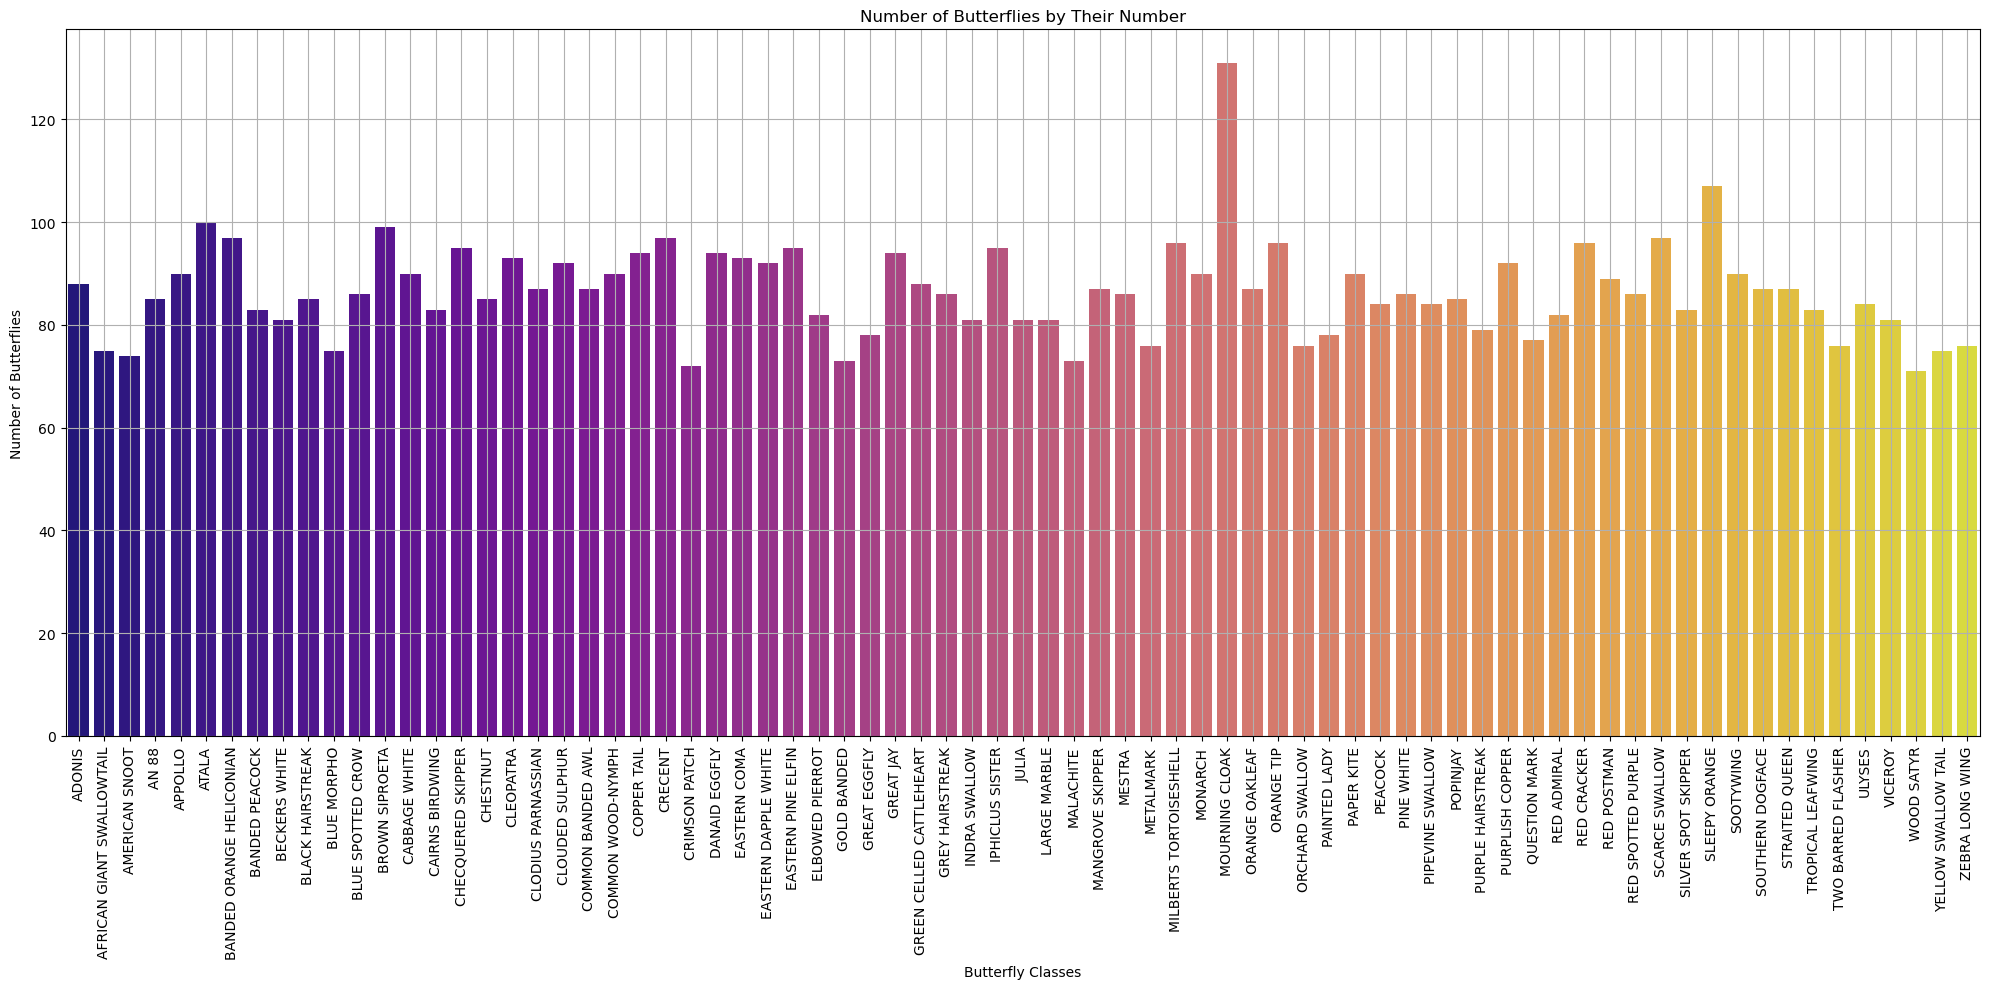

In [18]:
# Create another table and visualize number of butterflies by their number
class_counts = df_training['label'].value_counts().sort_index()
fig1 = plt.figure(figsize=(20, 10))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='plasma')
plt.title('Number of Butterflies by Their Number')
plt.xlabel('Butterfly Classes')
plt.ylabel('Number of Butterflies')
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

In [20]:
# Build a neural network model
model_NN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(75, activation='softmax')
])

# Compile the model
model_NN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary the model
model_NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        38,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,072,139 (72.75 MB)

 Trainable params: 19,072,139 (72.75 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the NN model with 40 epochs and get the highest accuracy value
history = model_NN.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=40,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 46s 280ms/step - accuracy: 0.0391 - loss: 4.2070 - val_accuracy: 0.1828 - val_loss: 3.1675
Epoch 2/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1562 - loss: 3.2803 - val_accuracy: 0.1813 - val_loss: 3.2047
Epoch 3/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 47s 291ms/step - accuracy: 0.1958 - loss: 3.0784 - val_accuracy: 0.2313 - val_loss: 2.9730
Epoch 4/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.2188 - loss: 2.6584 - val_accuracy: 0.2367 - val_loss: 2.9772
Epoch 5/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 48s 299ms/step - accuracy: 0.3091 - loss: 2.4916 - val_accuracy: 0.4391 - val_loss: 2.0367
Epoch 6/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3750 - loss: 2.1530 - val_accuracy: 0.4305 - val_loss: 2.0755
Epoch 7/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 50s 310ms/step - accuracy: 0.4200 - loss: 2.0259 - val_accuracy: 0.4719 - val_loss: 1.9311
Epoch 8/40
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3125 - loss: 2.3546 - 

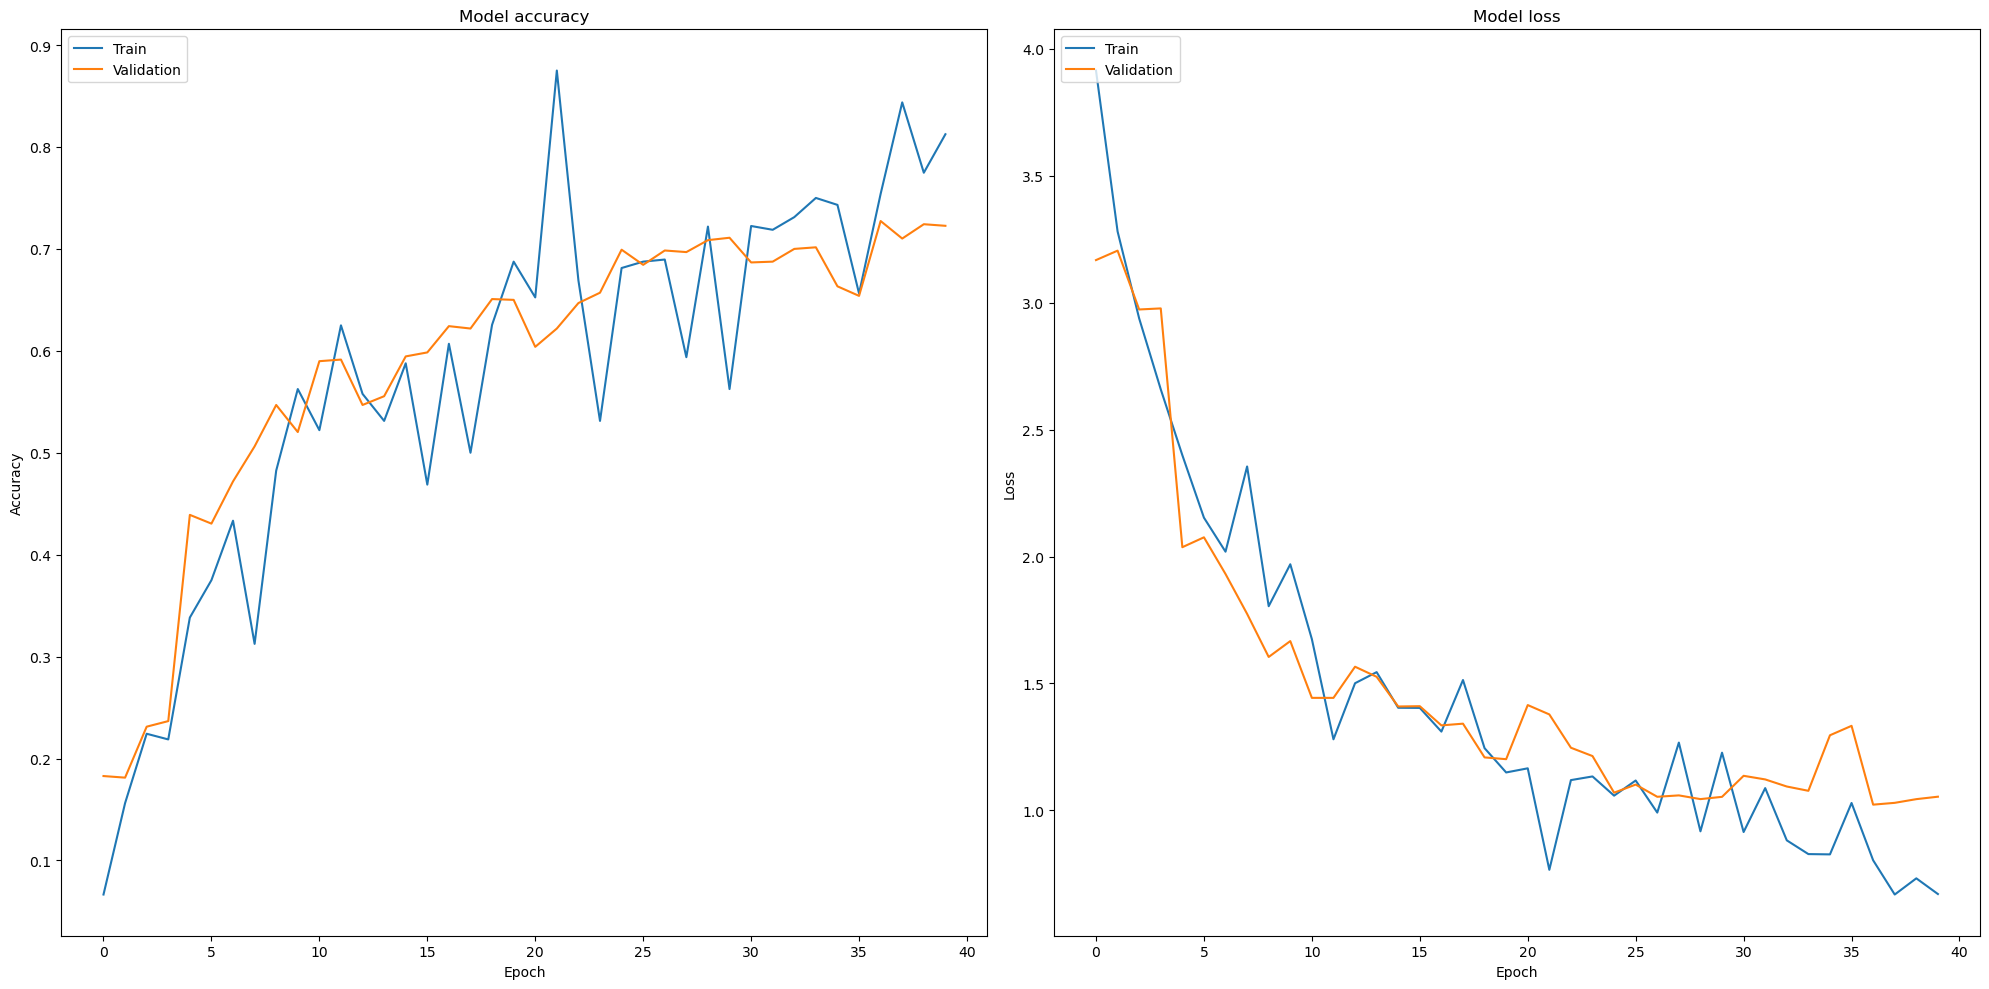

In [24]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(20, 10))

# First plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Second plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show plots
plt.tight_layout()
plt.show()

In [26]:
# Evaluate the model performance on validation data
val_loss, val_acc = model_NN.evaluate(val_generator)
print(f'Validation Accuracy: {val_acc}')
print(f'Validation Loss: {val_loss}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7291 - loss: 1.0621
Validation Accuracy: 0.7223076820373535
Validation Loss: 1.058054804801941


In [28]:
# Sample data set for ANN
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])
y = np.array([1, 2, 3, 4])

# Split and create ANN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# Compile model and training
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

# Prediction
y_pred = model.predict(X_test)

# MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape}')

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.8199  
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8655
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.9375
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1423
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1897
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1027 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3039
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0584
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1360
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2692
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2325
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3182
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1457
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2816
Epoch 16/100
3/3 ━━━━━━━━━━

In [30]:
# Fix file paths
df_training['full_path'] = df_training['filename'].apply(lambda x: os.path.join(image_dir, x))

# Check files
def check_image_exists(path):
    return os.path.exists(path) if not pd.isna(path) else False

df_training['image_exists'] = df_training['full_path'].apply(check_image_exists)

print("Total number of data:", len(df_training))
print("Images that did not exist:", (~df_training['image_exists']).sum())
print("Missing filenames:", df_training['filename'].isna().sum())
print("\nFirst 5 data:")
print(df_training.head())

# Tests
if any(df_training['image_exists']):
    test_image = df_training[df_training['image_exists']].iloc[0]['full_path']
    try:
        img = load_img(test_image, target_size=(224, 224))
        print(f"\nThis path can successfully load: {test_image}")
    except Exception as e:
        print(f"\nThis path cannot load: {e}")

Total number of data: 6499
Images that did not exist: 0
Missing filenames: 0

First 5 data:
      filename                     label  \
0  Image_1.jpg          SOUTHERN DOGFACE   
1  Image_2.jpg                    ADONIS   
2  Image_3.jpg            BROWN SIPROETA   
3  Image_4.jpg                   MONARCH   
4  Image_5.jpg  GREEN CELLED CATTLEHEART   

                                           full_path  image_exists  
0  /Users/shrutiraj/Downloads/archive-2/train/Ima...          True  
1  /Users/shrutiraj/Downloads/archive-2/train/Ima...          True  
2  /Users/shrutiraj/Downloads/archive-2/train/Ima...          True  
3  /Users/shrutiraj/Downloads/archive-2/train/Ima...          True  
4  /Users/shrutiraj/Downloads/archive-2/train/Ima...          True  

This path can successfully load: /Users/shrutiraj/Downloads/archive-2/train/Image_1.jpg


In [32]:
# Create a feature extraction function
def extract_features(image_path):
    if pd.isna(image_path) or not os.path.exists(image_path):
        print(f"Warning: File did not found - {image_path}")
        return [np.nan, np.nan, np.nan]
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return [
            np.mean(img_array[:,:,0]),
            np.mean(img_array[:,:,1]),
            np.mean(img_array[:,:,2])
        ]
    except Exception as e:
        print(f"Warning: {image_path} cannot load - {str(e)}")
        return [np.nan, np.nan, np.nan]

# Label encoder for label column
le = LabelEncoder()
df_training['label_code'] = le.fit_transform(df_training['label'])
df_training

# Extract features
features = [extract_features(f) for f in df_training['full_path']]
features_df = pd.DataFrame(features, columns=['x1', 'x2', 'x3'])
features_df['target'] = df_training['label_code']

# 2x2 matrix
matrix_data = pd.DataFrame({
    'x1': features_df['x1'],
    'x2': features_df['x2'],
    'x3': features_df['x3'],
    'x4': features_df['target']
})

print("2x2 Matrix Data:")
print("\nFirst 5 Rows:")
print(matrix_data.head())
print("\nMissing Value Numbers:")
print(matrix_data.isna().sum())

2x2 Matrix Data:

First 5 Rows:
         x1        x2        x3  x4
0  0.489953  0.522764  0.319078  66
1  0.412966  0.486659  0.449384   0
2  0.642400  0.585264  0.554508  12
3  0.673686  0.640516  0.446596  44
4  0.544185  0.531947  0.515353  33

Missing Value Numbers:
x1    0
x2    0
x3    0
x4    0
dtype: int64


In [33]:
# 10 random class
unique_classes = df_training['label_code'].unique()
selected_classes = random.sample(list(unique_classes), min(10, len(unique_classes)))

# 30 samples for each class
df_balanced = pd.DataFrame()
for class_label in selected_classes:
    class_data = df_training[df_training['label_code'] == class_label]
    valid_class_data = class_data[class_data['full_path'].notna()]
    
    if len(valid_class_data) >= 30:
        class_samples = valid_class_data.sample(n=30)
    else:
        print(f"Warning: For class {class_label}, we have {len(valid_class_data)} samples")
        class_samples = valid_class_data.sample(n=30, replace=True)
    
    df_balanced = pd.concat([df_balanced, class_samples])

# LOOCV and MAPE calculation
def calculate_mape_for_class(class_data):
    features = [extract_features(f) for f in class_data['full_path']]
    X = pd.DataFrame(features, columns=['x1', 'x2', 'x3']).dropna()
    y = class_data['label_code'].iloc[X.index]
    
    if len(X) == 0:
        print(f"Warning: There is no valid data here")
        return np.nan
    
    loo = LeaveOneOut()
    mape_scores = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = Sequential([
            Dense(64, activation='relu', input_shape=(3,)),
            Dense(32, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(0.001), loss='mse')
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        
        y_pred = model.predict(X_test)
        mape = mean_absolute_percentage_error([y_test], y_pred)
        mape_scores.append(mape)
    
    return np.mean(mape_scores)

# Calculate MAPE for all of classes
class_mape_scores = {}
for class_label in selected_classes:
    class_data = df_balanced[df_balanced['label_code'] == class_label]
    mape = calculate_mape_for_class(class_data)
    class_mape_scores[f'Class_{class_label}'] = mape

# Visualize results
plt.figure(figsize=(12, 6))
valid_scores = {k: v for k, v in class_mape_scores.items() if not np.isnan(v)}
sns.barplot(x=list(valid_scores.keys()), y=list(valid_scores.values()))
plt.xticks(rotation=45)
plt.title('MAPE Scores by Class')
plt.xlabel('Class')
plt.ylabel('MAPE')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [41]:
# Create data again, make it useful for our processes, and fix if there is a empty data
df_training = pd.read_csv("/Users/shrutiraj/Downloads/archive-2/Training_set.csv")
le = LabelEncoder()
df_training['label_code'] = le.fit_transform(df_training['label'])
df_training['full_path'] = df_training['filename'].apply(lambda x: os.path.join(image_dir, x))

def predict_missing_values(data):
    valid_features = []
    valid_labels = []
    missing_indices = []
    
    for idx, row in data.iterrows():
        if pd.isna(row['full_path']):
            missing_indices.append(idx)
        else:
            features = extract_features(row['full_path'])
            if not any(np.isnan(features)):
                valid_features.append(features)
                valid_labels.append(row['label_code'])
    
    if not valid_features:
        print("Warning: There is no valid data for training")
        return None
    
    # Train model
    X_train = np.array(valid_features)
    y_train = np.array(valid_labels)
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(3,)),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    print(f"Total number of missing data is {len(missing_indices)}")
    return missing_indices, model

missing_indices, model = predict_missing_values(df_training)
if model is not None:
    print("\nIndices of Missing Values:")
    print(missing_indices)

Total number of missing data is 0

Indices of Missing Values:
[]


In [43]:
df_training.isna().sum()

filename      0
label         0
label_code    0
full_path     0
dtype: int64

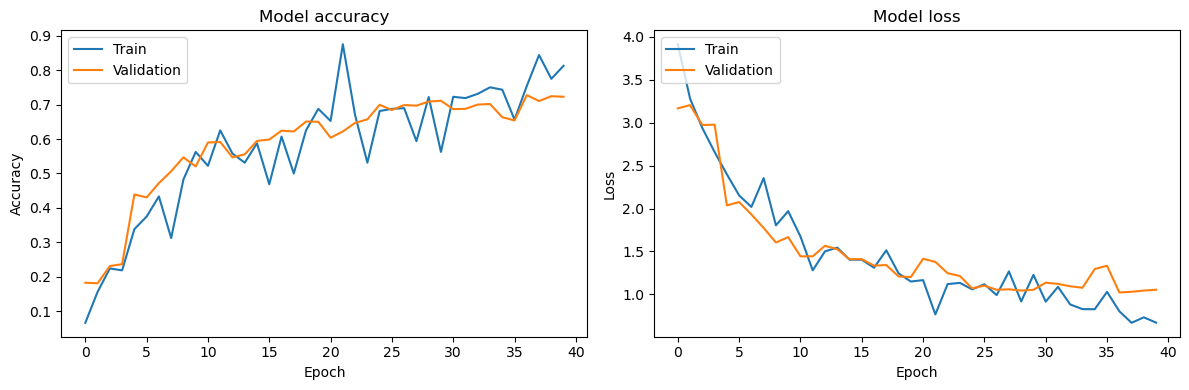

In [45]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()